# JOSS Paper Figures
Routines to create the figures for TidalPy's JOSS paper.

Last updated in November 2025 to work with at least TidalPy v0.7.0.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import cmcrameri.cm as cmc

import TidalPy
from TidalPy.structures import build_world, build_from_world, Orbit
from TidalPy.toolbox.quick_tides import dual_dissipation_from_dict_or_world_instance as calculate_dissipation
from TidalPy.utilities.conversions import orbital_motion2semi_a
from TidalPy.utilities.numpy_helper.array_other import neg_array_for_log_plot, find_nearest
from TidalPy.constants import radius_earth, mass_earth, mass_solar, radius_solar, au 

from helpers import planet_4layer, solve_venus

print(f"TidalPy Version: {TidalPy.version}.")

TidalPy Version: 0.6.11.


## Dynamic vs. Static Tides

In [18]:
days = np.linspace(0.5, 5, 150)
k2s_static = np.empty(days.shape, dtype=np.complex128)
k2s_dyn_incomp = np.empty(days.shape, dtype=np.complex128)
effective_q_static = np.empty(days.shape, dtype=np.float64)
effective_q_dynamic = np.empty(days.shape, dtype=np.float64)

for d_i, day in enumerate(days):
    print("Working on index:", d_i, end='\r')

    solution = planet_4layer(day, True, running_array=True)
    if solution.success:
        k2s_static[d_i] = solution.k
        effective_q_static[d_i] = solution.Q
    else:
        k2s_static[d_i] = np.nan
        effective_q_static[d_i] = np.nan

    solution = planet_4layer(day, False, True, running_array=True)
    if solution.success:
        k2s_dyn_incomp[d_i] = solution.k
        effective_q_dynamic[d_i] = solution.Q
    else:
        k2s_dyn_incomp[d_i] = np.nan
        effective_q_dynamic[d_i] = np.nan

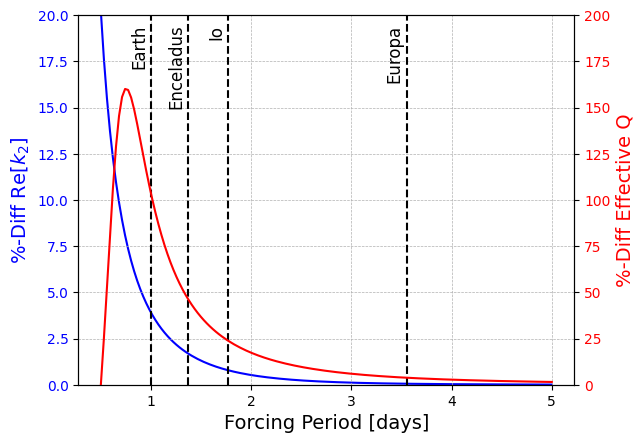

In [22]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

real_percent_diff = 100.0 * (np.real(k2s_dyn_incomp) - np.real(k2s_static)) / np.real(k2s_static)
imag_percent_diff = 100.0 * (np.imag(k2s_dyn_incomp) - np.imag(k2s_static)) / np.imag(k2s_static)
effective_Q_diff = 100.0 * (effective_q_dynamic - effective_q_static) / effective_q_static

ax.plot(days, real_percent_diff, c='b', ls='-', label='Static', zorder=1)
# ax.plot(days, np.real(k2s_dyn_incomp), c='b', ls='-', label='Dynamic')
ax2.plot(days, effective_Q_diff, c='r', ls='-', zorder=2)
# ax2.plot(days, -np.imag(k2s_dyn_incomp), c='r', ls='-')

objects = {
    'Enceladus': 1.37,
    'Europa': 3.551,
    'Io': 1.769,
    'Earth': 1.0,
}

for name, period in objects.items():
    ax.axvline(x=period, linestyle='--', c='k')
    txt = ax.text(
        period - 0.12,
        0.92*ax.get_ylim()[1],
        name,
        rotation=90,
        verticalalignment='top',
        horizontalalignment='center',
        fontsize=12,
        zorder=10)

ax.set_ylabel('%-Diff Re[$k_2$]', c='b', fontsize=14)
ax2.set_ylabel('%-Diff Effective Q', c='r', fontsize=14)
ax.set_xlabel('Forcing Period [days]', fontsize=14)
ax.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylim(0, 200)
ax.set_ylim(0, 20)
for tick in ax.get_yticklabels():
    tick.set_color('b')
for tick in ax2.get_yticklabels():
    tick.set_color('r')

ax.grid(True, which='both', ls='--', lw=0.5)
ax.legend
plt.show()
fig.savefig("dynamic_vs_static_tides.png", dpi=300)

# Bulk Compressibility

In [31]:
bulk_moduli = np.linspace(100.0e9, 350.0e9, 100)
inner_core_fraction = np.linspace(0.1, 0.4, 100)

ic_f, bm = np.meshgrid(inner_core_fraction, bulk_moduli)

k_tidal_incomp = np.empty(bm.shape, dtype=np.complex128)
k_loading_incomp = np.empty(bm.shape, dtype=np.complex128)
k_tidal_comp = np.empty(bm.shape, dtype=np.complex128)
k_loading_comp = np.empty(bm.shape, dtype=np.complex128)

for i in range(bulk_moduli.size):
    print("Working on index:", i, end='\r')
    for j in range(inner_core_fraction.size):
        solution_incomp = solve_venus(ic_f[i, j], bm[i, j], is_incomp=True)
        
        if solution_incomp.success:
            k_tidal_incomp[i, j] = solution_incomp.k[0]
            k_loading_incomp[i, j] = solution_incomp.k[1]
        else:
            k_tidal_incomp[i, j] = np.nan * (1 + 1j)
            k_loading_incomp[i, j] = np.nan * (1 + 1j)
        
        solution_comp = solve_venus(ic_f[i, j], bm[i, j], is_incomp=False)

        if solution_comp.success:
            k_tidal_comp[i, j] = solution_comp.k[0]
            k_loading_comp[i, j] = solution_comp.k[1]
        else:
            k_tidal_comp[i, j] = np.nan * (1 + 1j)
            k_loading_comp[i, j] = np.nan * (1 + 1j)

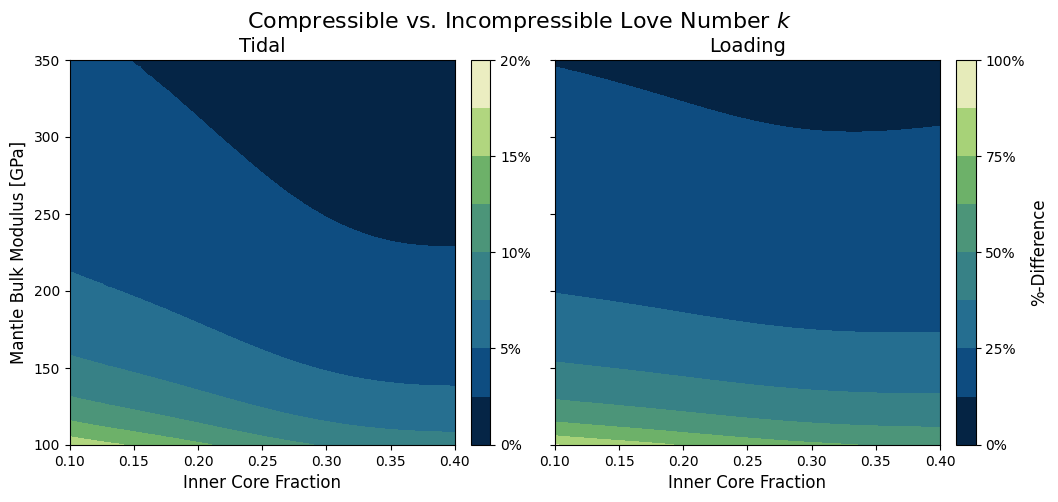

In [32]:
tidal_percent_diff = 100.0 * (np.real(k_tidal_incomp) - np.real(k_tidal_comp)) / np.real(k_tidal_incomp)
loading_percent_diff = 100.0 * (np.real(k_loading_incomp) - np.real(k_loading_comp)) / np.real(k_loading_incomp)


fig, axes = plt.subplots(1, 4, figsize=(12, 5), width_ratios=[1, 0.05, 1, 0.05])
fig.suptitle('Compressible vs. Incompressible Love Number $k$', fontsize=16)
fig.subplots_adjust(wspace=0.2)

# Shift figures a bit to the left
box = axes[1].get_position()
axes[1].set_position([box.x0 - 0.02, box.y0, box.width, box.height])
box = axes[3].get_position()
axes[3].set_position([box.x0 - 0.02, box.y0, box.width, box.height])

cbars = list()
cs1 = axes[0].contourf(
    inner_core_fraction,
    bulk_moduli / 1e9,
    np.abs(tidal_percent_diff),
    levels=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20],
    cmap=cmc.navia)
cbars.append(plt.colorbar(cs1, cax=axes[1], orientation='vertical', pad=0.0))
axes[0].set_title('Tidal', fontsize=14)


cs2 = axes[2].contourf(
    inner_core_fraction,
    bulk_moduli / 1e9,
    np.abs(loading_percent_diff),
    levels=[0, 12, 25, 37, 50, 63, 75, 85, 100],
    cmap=cmc.navia)
cbars.append(plt.colorbar(cs2, cax=axes[3], orientation='vertical', pad=0.0))
axes[2].set_title('Loading', fontsize=14)

for a_i, ax in enumerate(axes):

    if a_i == 0:
        ax.set_ylabel('Mantle Bulk Modulus [GPa]', fontsize=12)
        ax.set_xlabel('Inner Core Fraction', fontsize=12)
    elif a_i == 1:
        # cbars[0].set_label('%-Difference', fontsize=12)
        cbars[0].set_ticks([0, 5, 10, 15, 20])
        cbars[0].set_ticklabels(['0%', '5%', '10%', '15%', '20%'])
        pass
    elif a_i == 2:
        # ax.set_ylabel('Mantle Bulk Modulus [GPa]', fontsize=12)
        ax.set_yticklabels([])
        ax.set_xlabel('Inner Core Fraction', fontsize=12)
    else:
        cbars[1].set_label('%-Difference', fontsize=12)
        cbars[1].set_ticks([0, 25, 50, 75, 100])
        cbars[1].set_ticklabels(['0%', '25%', '50%', '75%', '100%'])


fig.savefig("compressibility_effects_venus.png", dpi=300)


# Rheology Comparison

In [16]:
import warnings
warnings.filterwarnings("ignore")

# Build Io
io_base = build_world('io')

# Setup domain and plot
temperature = np.linspace(1000., 1850., 100)

# Lets show how different rheological models can impact tidal heating
fixed_q = 10.
rheologies = {
    'maxwell': ('Maxwell (Traditional Method)', 'k'),
    'burgers': ('Burgers', 'r'),
    'andrade': ('Andrade', 'b'),
    'sundberg': ('Sundberg-Cooper', 'm')
}
orbit_by_rheo = {}

r_i = 0
for rheo_model, (rheo_name, rheo_color) in rheologies.items():
    
    # Build a new Io assuming its mantle has this new rheology.
    #    Note: Building a whole new world just to see the difference in
    #       in rheology is overkill - this is just a demonstration.
    new_config = {'layers': {'Mantle': {'rheology': {'model': rheo_model}}}}
    io = build_from_world(io_base, new_config=new_config)
    
    # Set fixed q if that model is being used
    if rheo_model.lower() in ['fixed_q']:
        io.tides.set_fixed_q(fixed_q, run_updates=False)
    
    # Load in temperatures and make tidal calculations
    io.mantle.temperature = temperature
    
    # Add orbit with jupiter (load in default orbital configurations based on Io's config)
    sol = build_world('sol')
    jupiter = build_world('jupiter')
    orbit = Orbit(star=sol, tidal_host=jupiter, tidal_bodies=io)
    # Set orbits time to initialize the world's radiogenic heating
    orbit.time = 4600.  # 4600. Myr after solar system formation is roughly modern.
    
    # Store the orbit by rheology
    orbit_by_rheo[(rheo_name, rheo_color)] = orbit
    
    r_i += 1

One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or mor

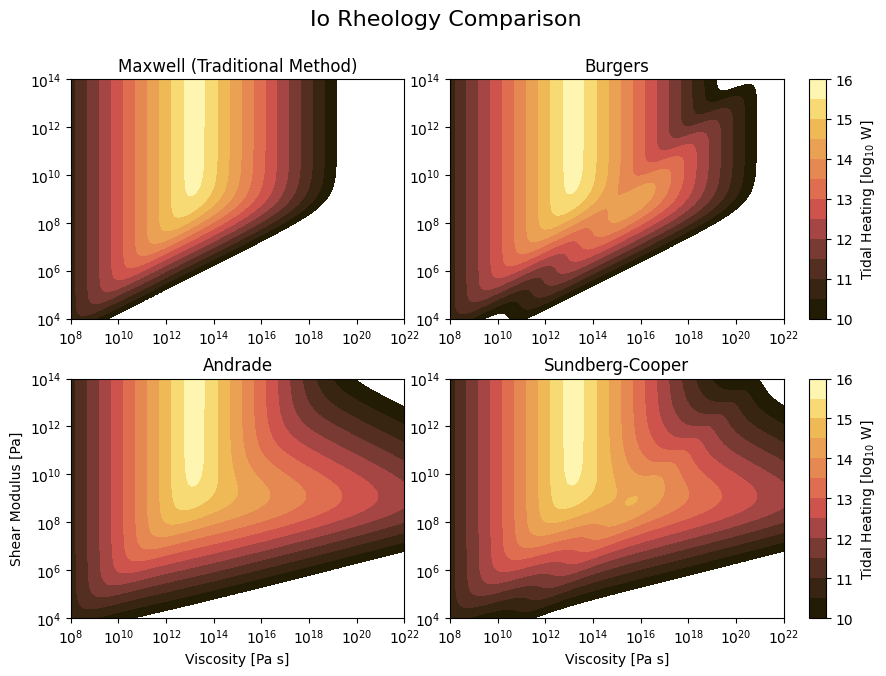

In [20]:
# Create figure and gridspec: 2 rows, 3 columns (last column for colorbars)
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1, 1, 0.05], wspace=0.2, hspace=0.25)
fig.suptitle("Io Rheology Comparison", fontsize=16)

# Axes for plots
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

# Axes for colorbars (one for each row, or you can do one per plot)
cbar_axes = [
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 2])
]


viscosity_array = np.logspace(8, 22, 100)
shear_array = np.logspace(4, 14, 110)
viscosity_mtx, shear_mtx = np.meshgrid(viscosity_array, shear_array)
shape = viscosity_mtx.shape
viscosity_mtx_flat = viscosity_mtx.flatten()
shear_mtx_flat = shear_mtx.flatten()

# Colorbar slices
colorbar_points = np.linspace(10, 16, 13)
colorbars = dict()

# Example plotting loop
i = 0
for (rheo_name, rheo_color), orbit in orbit_by_rheo.items():
    io = orbit.tidal_objects[1]

    # Set thermal state
    io.mantle.temperature = None  # Clear the temperature set in the previous cell.
    io.mantle.set_strength(viscosity=viscosity_mtx_flat, shear_modulus=shear_mtx_flat)
    
    tidal_heating = io.tidal_heating_global
    tidal_heating = np.log10(tidal_heating.reshape(shape))

    # Plot contour
    cb_data = axes[i].contourf(viscosity_array, shear_array, tidal_heating, colorbar_points, cmap=cmc.lajolla)
    axes[i].set_title(rheo_name)
    
    # Attach colorbar for the row
    if i % 2 == 1:  # for the second column in each row
        cbax = cbar_axes[i//2]
        cb = plt.colorbar(cb_data, cax=cbax)
        cb.set_label('Tidal Heating [log$_{10}$ W]')
        axes[i].set_yticklabels([])
    
        # Shift the colorbar to the left
        box = cbax.get_position()
        cbax.set_position([box.x0 - 0.02, box.y0, box.width, box.height])
    
    i += 1

# Set axis scales and labels
axes[0].set(xscale='log', yscale='log', ylim=(1e4, 1e14), xlim=(1e8, 1e22))
axes[1].set(xscale='log', yscale='log', ylim=(1e4, 1e14), xlim=(1e8, 1e22))
axes[2].set(xscale='log', yscale='log', ylim=(1e4, 1e14), xlim=(1e8, 1e22), xlabel='Viscosity [Pa s]', ylabel='Shear Modulus [Pa]')
axes[3].set(xscale='log', yscale='log', ylim=(1e4, 1e14), xlim=(1e8, 1e22), xlabel='Viscosity [Pa s]')

fig.savefig("io_rheology_comparison.png", dpi=300)

# Spin Orbit Resonances

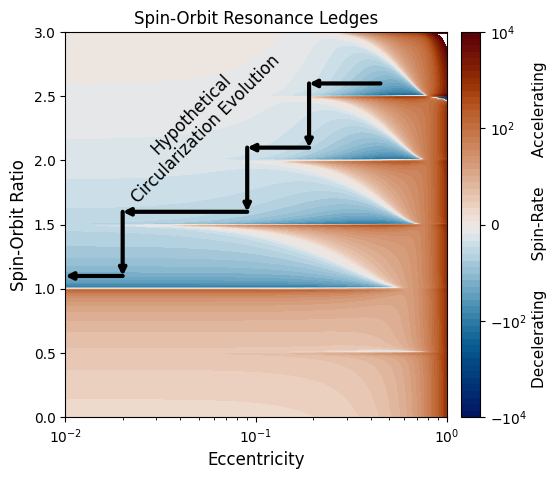

In [97]:
# Build a simple homogenious planet around a star
host = build_world('sol')
planet = build_world('earth_simple')
orbital_period = 6.  # days
target_obliquity = 0.  # degrees
target_viscosity = 1.e22  # Pa s
target_shear = 50.e9  # Pa
target_rheo = 'Maxwell'
target_k2 = 0.33
target_q = 100.
host_k2 = 0.33
host_q = 100.
host_obliquity = 0.  # degrees
host_spin_period = None  # days, None means synchronous with orbit
resolution = 500
year_scale = 1e2

# --- Setup domains and constants (same as original) ---
constant_orbital_freq = 2. * np.pi / (orbital_period * 86400.)
if host_spin_period is None:
    constant_host_spin_rate = constant_orbital_freq
else:
    constant_host_spin_rate = 2. * np.pi / (host_spin_period * 86400.)
constant_semi_major_axis = orbital_motion2semi_a(constant_orbital_freq, host.mass, planet.mass)


# Rheological Parameters
rheologies = {
    'Andrade': ('b', 'andrade', (0.3, 1.0)),
    'Maxwell': ('k', 'maxwell', tuple()),
    'Sundberg': ('m', 'sundberg', (0.2, 0.02, 0.3, 1.0)),
    'Sundberg-Cooper': ('m', 'sundberg', (0.2, 0.02, 0.3, 1.0)),
    'CPL': ('g', 'cpl', tuple()),
    'CTL': ('c', 'ctl', tuple()),
    'Off': ('gray', 'Off', tuple())
}
rheo_color, rheo_name, rheo_input = rheologies[target_rheo]
use_obliquity = (target_obliquity != 0.) or (host_obliquity != 0.)

eccentricity_domain = np.logspace(-2,0,int(resolution/2))
spin_scale_domain = np.linspace(0.,3.,int(resolution/2))
spin_scale_domain_res = np.asarray([0.5,1.,1.5,2.,2.5,3.])
spin_scale_domain = np.sort(np.concatenate((spin_scale_domain, spin_scale_domain_res)))
spin_domain = spin_scale_domain * constant_orbital_freq
eccentricity, spin_rate = np.meshgrid(eccentricity_domain, spin_domain)
shape = eccentricity.shape
eccentricity = eccentricity.flatten()
spin_rate = spin_rate.flatten()

# --- Find spin_sync index ---
sync_index = find_nearest(spin_scale_domain, 1.)

# --- Prepare figure for last panel ---
fig, ax = plt.subplots(figsize=(6,5))

# Only the last case
degree_l = 2
eccentricity_trunc = 20
case_name = f'$l={degree_l}, O(e^{eccentricity_trunc})$'

# --- Compute dissipation for the last case ---
dissipation_results = calculate_dissipation(
    host, planet,
    viscosities=(None, target_viscosity), shear_moduli=(None, target_shear),
    rheologies=('fixed_q', rheo_name), complex_compliance_inputs=(None, rheo_input),
    obliquities=(host_obliquity, target_obliquity),
    spin_frequencies=(constant_host_spin_rate, spin_rate),
    tidal_scales=(1.,1.),
    fixed_k2s=(host_k2, target_k2), fixed_qs=(host_q, target_q),
    eccentricity=eccentricity, orbital_frequency=constant_orbital_freq,
    max_tidal_order_l=degree_l, eccentricity_truncation_lvl=eccentricity_trunc,
    use_obliquity=use_obliquity,
    da_dt_scale=(3.154e7/1000.), de_dt_scale=3.154e7,
    dspin_dt_scale=((360./(2.*np.pi))*3.154e7**2)
)
tidal_heating_targ = dissipation_results['secondary']['tidal_heating']
dspin_dt_targ = dissipation_results['secondary']['spin_rate_derivative']
de_dt = dissipation_results['eccentricity_derivative']
da_dt = dissipation_results['semi_major_axis_derivative']

# Reshape
tidal_heating_targ = tidal_heating_targ.reshape(shape)
dspin_dt_targ = dspin_dt_targ.reshape(shape)
de_dt = de_dt.reshape(shape)

# Prep for log plotting
dspin_dt_targ *= year_scale**2
de_dt *= year_scale
dspin_dt_targ_pos, dspin_dt_targ_neg = neg_array_for_log_plot(dspin_dt_targ)
de_dt_pos, de_dt_neg = neg_array_for_log_plot(de_dt)

# Make data Symmetric Log (for negative logscale plotting)
logpos = np.log10(np.copy(dspin_dt_targ_pos))
logpos[logpos < 0.] = 0.
negative_index = ~np.isnan(dspin_dt_targ_neg)
logneg = np.log10(dspin_dt_targ_neg[negative_index])
logneg[logneg < 0.] = 0.
dspin_dt_targ_combo = logpos
dspin_dt_targ_combo[negative_index] = -logneg

# --- Plot contour ---
zpoints=np.linspace(-4, 4, 60)
zticks=(-4, -2, 0, 2, 4)
ztick_names = ('$-10^{4}$', '$-10^{2}$', '$0$', '$10^{2}$', '$10^{4}$')

cb_data = ax.contourf(eccentricity_domain, spin_scale_domain, dspin_dt_targ_combo, zpoints, cmap=cmc.vik)
ax.set_xlabel('Eccentricity', fontsize=12)
ax.set_ylabel('Spin-Orbit Ratio', fontsize=12)
ax.set(title="Spin-Orbit Resonance Ledges", xscale='log', yscale='linear')

# --- Colorbar ---
cb = plt.colorbar(cb_data, ax=ax, pad=0.03, ticks=zticks)
cb.set_label('Decelerating      Spin-Rate      Accelerating', fontsize=11)
cb.ax.set_yticklabels(ztick_names)

# Example coordinates for ledges (theta/n, eccentricity)
# You need to tune these to match your data
ledges = [
    (0.45, 2.6),
    (0.19, 2.1),
    (0.09, 1.6),
    (0.02, 1.1),
    (0.01, 1.1),
]

# Loop through ledges and draw arrows down to next
for i in range(len(ledges)-1):
    start = ledges[i]
    end = ledges[i+1]
    # Draw arrow "falling off" ledge
    ax.annotate(
        "", xy=(end[0], start[1]), xytext=start,
        arrowprops=dict(arrowstyle="->", color='k', lw=3, alpha=1,
                        shrinkA=0, shrinkB=0)
    )
    ax.annotate(
        "", xy=end, xytext=(end[0], start[1]),
        arrowprops=dict(arrowstyle="->", color='k', lw=3, alpha=1,
                        shrinkA=0, shrinkB=0)
    )

# Add annotation text
ax.text(0.05, 2.3, "Hypothetical\nCircularization Evolution",
        color='black', fontsize=12, ha='center', va='center', rotation=45)

plt.show()
fig.savefig("spin_orbit_resonance_ledges.png", dpi=300)

In [31]:
dspin_dt_targ_combo


array([[ 0.        ,  0.        ,  0.        , ...,  3.03138376,
         3.17110277,  3.31353904],
       [ 0.        ,  0.        ,  0.        , ...,  3.03149057,
         3.17120517,  3.31363759],
       [ 0.        ,  0.        ,  0.        , ...,  3.03159747,
         3.17130764,  3.3137362 ],
       ...,
       [-0.        , -0.        , -0.        , ...,  2.98413921,
         3.11268488,  3.24330866],
       [-0.        , -0.        , -0.        , ...,  3.11735507,
         3.26277004,  3.41144245],
       [-0.        , -0.        , -0.        , ...,  3.11735507,
         3.26277004,  3.41144245]])